<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/inference_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to import inference labels

In this tutorial, we will walk through the process of using Kili to evaluate the performance of a machine learning model in production.

We will learn how to push model-generated labels to Kili and how to visualize their quality.

In [ ]:
%pip install kili

In [ ]:
import getpass
import os

from kili.client import Kili

if "KILI_API_KEY" not in os.environ:
    KILI_API_KEY = getpass.getpass("Please enter your API key: ")
else:
    KILI_API_KEY = os.environ["KILI_API_KEY"]

kili = Kili(
    api_key=KILI_API_KEY,  # no need to pass the API_KEY if it is already in your environment variables
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

## Context

### Agreement

Let's say you have a trained machine learning model $m$, which can, given data $x$, output a prediction (i.e., an inference label): $\hat{y} = m(x)$.

What you will probably want to do is monitor the quality of such predictions, as the model evolves.
Kili allows you to better monitor and iterate on your model, thanks to the concept of agreement.
An agreement is a quantitative measure of similarity between two different labels.
In Kili, there are three main features derived from agreement: 

- [**Consensus**](https://docs.kili-technology.com/docs/consensus-overview), which is the agreement between two labelers.
- [**Honeypot**](https://docs.kili-technology.com/docs/honeypot-overview), which is the agreement between a "super human annotator" and a labeler.
- **Inference**, which is the agreement between a model-generated label and a human.

Those numbers can be monitored from the [queue page](https://docs.kili-technology.com/docs/queue-page) or the [analytics page](https://docs.kili-technology.com/docs/analytics-page). You can find how the agreement is computed [here](https://docs.kili-technology.com/docs/calculation-rules-for-quality-metrics).

In this tutorial, we will put an emphasis on **Inference**.

### Use cases 

We identify two main use cases for the use of **inference** labels.

The first use case is when you have a model in production.
When it receives assets, it automatically feeds a Kili project with both the asset and the predicted label.
You also have human workforce whose job is to monitor the quality of the model.
They manually label a portion of the data after it had been pre-labeled by the model.
When a human submits a label, the inference score (model vs. human) for that label is automatically computed.
Low inference scores can indicate either a model performing badly on some kind of data, or a disagreement between humans and the model.
This can help you to:

- Detect data drift.
- Identify data on which the model needs improvement.
      
The second use case is when you used Kili to label data and you have the first iteration of your model.
You can now use a part of the labeled dataset as testing data, and quickly get test scores.
Of course, you could use your own metrics (rather than our own definition of agreement), but using Kili lets you quickly filter and indentify the assets where your model differs the most from the ground truth.

- When you push an inference-type label to an asset, the inference score is automatically computed for the most recent label added to this asset.
- You can filter on low inference score, to understand why your model is failing, and how to fix it (getting more data, splitting or merging categories, etc.).

With Kili, you can quickly iterate on the data used to train your model, to get a better model faster.

## In practice

### Use case 1

We start by creating a project and defining a model which, given an asset input $x$, returns a category (random in our example):

In [ ]:
json_interface = {
    "jobs": {
        "CLASSIFICATION_JOB": {
            "mlTask": "CLASSIFICATION",
            "content": {
                "categories": {
                    "RED": {"name": "Red"},
                    "BLACK": {"name": "Black"},
                    "WHITE": {"name": "White"},
                    "GREY": {"name": "Grey"},
                },
                "input": "radio",
            },
            "required": 0,
            "isChild": False,
            "instruction": "Color",
        }
    }
}

project_id = kili.create_project(
    title="[Kili SDK Notebook]: Project demo inference",
    input_type="IMAGE",
    json_interface=json_interface,
)["id"]

Then we can simulate that our model is in production.
Each time it receives an asset, we upload it to Kili along with the predicted label.

In [ ]:
stream_of_assets = [
    {
        "url": (
            "https://storage.googleapis.com/label-public-staging/recipes/inference/black_car.jpg"
        ),
        "external_id": "black_car.jpg",
    },
    {
        "url": "https://storage.googleapis.com/label-public-staging/recipes/inference/grey_car.jpg",
        "external_id": "grey_car.jpg",
    },
    {
        "url": (
            "https://storage.googleapis.com/label-public-staging/recipes/inference/white_car.jpg"
        ),
        "external_id": "white_car.jpg",
    },
    {
        "url": "https://storage.googleapis.com/label-public-staging/recipes/inference/red_car.jpg",
        "external_id": "red_car.jpg",
    },
]

We import the assets into the Kili project:

In [ ]:
kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[asset["url"] for asset in stream_of_assets],
    external_id_array=[asset["external_id"] for asset in stream_of_assets],
)

We simulate some model predictions:

In [ ]:
predictions = {
    "black_car.jpg": "WHITE",
    "grey_car.jpg": "GREY",
    "white_car.jpg": "RED",
    "red_car.jpg": "BLACK",
}

And we upload those predictions to Kili:

In [ ]:
predicted_categories = [predictions[asset["external_id"]] for asset in stream_of_assets]
inference_labels = [
    {"CLASSIFICATION_JOB": {"categories": [{"name": predicted_category}]}}
    for predicted_category in predicted_categories
]

kili.append_labels(
    project_id=project_id,
    asset_external_id_array=[asset["external_id"] for asset in stream_of_assets],
    json_response_array=inference_labels,
    label_type="INFERENCE",  # We import model-generated labels as "INFERENCE" labels
    model_name="my_model",
)

Then, human labelers can annotate a subsample of the assets pushed to Kili. 

Note: you can automatically [prioritize assets](https://docs.kili-technology.com/docs/queue-prioritization) to be reviewed by a human by using the model's certainty score. When the model is unsure of its predictions, this may indicate wrong labels.

In [ ]:
ground_truths = {
    "black_car.jpg": "BLACK",
    "grey_car.jpg": "GREY",
    "white_car.jpg": "WHITE",
    "red_car.jpg": "RED",
}

human_labels = [
    {"CLASSIFICATION_JOB": {"categories": [{"name": ground_truths[asset["external_id"]]}]}}
    for asset in stream_of_assets
]
kili.append_labels(
    project_id=project_id,
    json_response_array=human_labels,
    asset_external_id_array=[asset["external_id"] for asset in stream_of_assets],
    label_type="DEFAULT",
)

You can now fetch the agreement between the human and the model, for human labels:

In [ ]:
labels = kili.labels(
    project_id=project_id, fields=["inferenceMark", "id", "labelOf.id"], type_in=["DEFAULT"]
)
print(labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.43it/s]

[{'labelOf': {'id': 'cleoicx8s0000h8vzn0qu3mpz'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02eg0jx8cub2c6q6'}, {'labelOf': {'id': 'cleoicx8s0001h8vzh742in5x'}, 'inferenceMark': 1, 'id': 'cleoicz3b02eh0jx8fe1iap2a'}, {'labelOf': {'id': 'cleoicx8s0002h8vz0jhz2co8'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02ei0jx8bi4ifnkw'}, {'labelOf': {'id': 'cleoicx8s0003h8vzbiaawl1j'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02ej0jx86n5c2m0a'}]


In [ ]:
# we test that label["inferenceMark"] should always be <= 1

assets = kili.assets(project_id=project_id)

for label in labels:
    external_id = [
        asset["externalId"] for asset in assets if asset["id"] == label["labelOf"]["id"]
    ][0]

    if predictions[external_id] == ground_truths[external_id]:
        assert label["inferenceMark"] == 1
    else:
        assert label["inferenceMark"] < 1

print(labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.85it/s]

[{'labelOf': {'id': 'cleoicx8s0000h8vzn0qu3mpz'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02eg0jx8cub2c6q6'}, {'labelOf': {'id': 'cleoicx8s0001h8vzh742in5x'}, 'inferenceMark': 1, 'id': 'cleoicz3b02eh0jx8fe1iap2a'}, {'labelOf': {'id': 'cleoicx8s0002h8vz0jhz2co8'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02ei0jx8bi4ifnkw'}, {'labelOf': {'id': 'cleoicx8s0003h8vzbiaawl1j'}, 'inferenceMark': 0.5, 'id': 'cleoicz3b02ej0jx86n5c2m0a'}]


This allows you to identify problems:

In [ ]:
for label in labels:
    # this label has disagreement between human and model
    if label["inferenceMark"] < 1:
        asset_id = label["labelOf"]["id"]
        # get the model-generated label
        inference_label = kili.labels(
            project_id=project_id,
            asset_id=asset_id,
            type_in=["INFERENCE"],
            output_format="parsed_label",
            disable_tqdm=True,
        )[0]
        # get the human-made label
        human_label = kili.labels(
            project_id=project_id,
            label_id=label["id"],
            output_format="parsed_label",
            disable_tqdm=True,
        )[0]

        inference_category = inference_label.jobs["CLASSIFICATION_JOB"].category.name
        human_category = human_label.jobs["CLASSIFICATION_JOB"].category.name
        print(
            f"The model predicted {inference_category} but the human predicted {human_category} for"
            f" asset with id {asset_id}."
        )

The model predicted WHITE but the human predicted BLACK for asset with id cleoicx8s0000h8vzn0qu3mpz.
The model predicted RED but the human predicted WHITE for asset with id cleoicx8s0002h8vz0jhz2co8.
The model predicted BLACK but the human predicted RED for asset with id cleoicx8s0003h8vzbiaawl1j.


You can also find the assets with most disagreement directly from the interface with the "Human/Model IoU" filter.

Low IoU indicates low agreement:

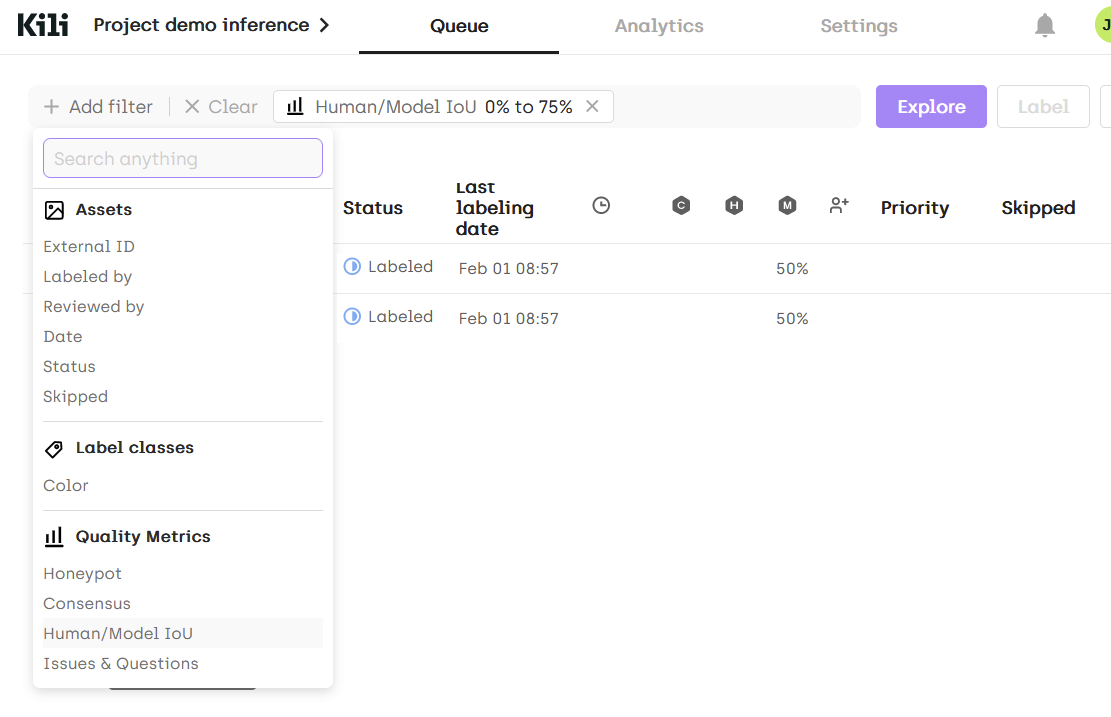

In [ ]:
kili.delete_project(project_id)

### Use case 2

We can invert the previous use case.

We start with a human-labeled dataset and we insert model predictions to it, to simulate testing our model on test data.

In [ ]:
project_id = kili.create_project(
    title="[Kili SDK Notebook]: Project demo inference 2",
    input_type="IMAGE",
    json_interface=json_interface,
)["id"]

In [ ]:
labeled_assets = [
    {
        "url": (
            "https://storage.googleapis.com/label-public-staging/recipes/inference/black_car.jpg"
        ),
        "external_id": "black_car.jpg",
    },
    {
        "url": "https://storage.googleapis.com/label-public-staging/recipes/inference/grey_car.jpg",
        "external_id": "grey_car.jpg",
    },
    {
        "url": (
            "https://storage.googleapis.com/label-public-staging/recipes/inference/white_car.jpg"
        ),
        "external_id": "white_car.jpg",
    },
    {
        "url": "https://storage.googleapis.com/label-public-staging/recipes/inference/red_car.jpg",
        "external_id": "red_car.jpg",
    },
]

In [ ]:
kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[asset["url"] for asset in labeled_assets],
    external_id_array=[asset["external_id"] for asset in labeled_assets],
)

`ground_truths` represents labels made by human annotators:

In [ ]:
ground_truths = {
    "black_car.jpg": "BLACK",
    "grey_car.jpg": "GREY",
    "white_car.jpg": "WHITE",
    "red_car.jpg": "RED",
}

Now, we import the human labels:

In [ ]:
human_labels = [
    {"CLASSIFICATION_JOB": {"categories": [{"name": ground_truths[asset["external_id"]]}]}}
    for asset in labeled_assets
]

kili.append_labels(
    project_id=project_id,
    json_response_array=human_labels,
    asset_external_id_array=[asset["external_id"] for asset in labeled_assets],
    label_type="DEFAULT",
)

We take 80% of the training data and use it to train a model.

We can then run the trained model against the remaining 20% of the labeled assets, and upload predictions to Kili:

In [ ]:
test_labels = [
    {"CLASSIFICATION_JOB": {"categories": [{"name": predictions[asset["external_id"]]}]}}
    for asset in labeled_assets
]
kili.append_labels(
    project_id=project_id,
    json_response_array=test_labels,
    asset_external_id_array=[asset["external_id"] for asset in labeled_assets],
    label_type="INFERENCE",
    model_name="my_model",
)

In [ ]:
labels = kili.labels(
    project_id=project_id, fields=["inferenceMark", "id", "labelOf.id"], type_in=["DEFAULT"]
)
print(labels)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.31it/s]

[{'labelOf': {'id': 'cleoid2lk0004h8vzyqb6bfp5'}, 'inferenceMark': 0.5, 'id': 'cleoid3m802fg0jx831mhak3l'}, {'labelOf': {'id': 'cleoid2lk0005h8vzmodn4ce8'}, 'inferenceMark': 1, 'id': 'cleoid3m802fh0jx893nia1og'}, {'labelOf': {'id': 'cleoid2lk0006h8vza2xtc6h5'}, 'inferenceMark': 0.5, 'id': 'cleoid3m802fi0jx861b52nd5'}, {'labelOf': {'id': 'cleoid2lk0007h8vzkp2yodiu'}, 'inferenceMark': 0.5, 'id': 'cleoid3m802fj0jx8g5xj0lt2'}]


In [ ]:
# we test that label["inferenceMark"] should always be <= 1
assets = kili.assets(project_id=project_id)

for label in labels:
    external_id = [
        asset["externalId"] for asset in assets if asset["id"] == label["labelOf"]["id"]
    ][0]
    if predictions[external_id] == ground_truths[external_id]:
        assert label["inferenceMark"] == 1
    else:
        assert label["inferenceMark"] < 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.40it/s]


We can now print out a list of disagreements between human and machine labels:

In [ ]:
for label in labels:
    if label["inferenceMark"] < 1:
        inference_label = list(
            kili.labels(
                project_id=project_id,
                asset_id=label["labelOf"]["id"],
                type_in=["INFERENCE"],
                output_format="parsed_label",
                disable_tqdm=True,
            )
        )[0]
        human_label = list(
            kili.labels(
                project_id=project_id,
                label_id=label["id"],
                output_format="parsed_label",
                disable_tqdm=True,
            )
        )[0]

        inference_category = inference_label.jobs["CLASSIFICATION_JOB"].category.name
        human_category = human_label.jobs["CLASSIFICATION_JOB"].category.name

        print(
            f"The human predicted {human_category} but the model predicted {inference_category} for"
            f" asset with id {asset_id}."
        )

The human predicted BLACK but the model predicted WHITE for asset with id cleoicx8s0003h8vzbiaawl1j.
The human predicted WHITE but the model predicted RED for asset with id cleoicx8s0003h8vzbiaawl1j.
The human predicted RED but the model predicted BLACK for asset with id cleoicx8s0003h8vzbiaawl1j.


In [ ]:
kili.delete_project(project_id)

## Conclusion

Congratulations! You can now upload your own inference labels to your Kili project 🚀.